# Homework 6
This homework builds on the effective visualization workshop with the Star Trek data. Below is what we completed in class. Output is suppressed for readability, but you can remove the supression on your code if you'd like.

In [1]:
invisible({
suppressPackageStartupMessages(library(tidyverse))

# Get the data.
dialogs <- read_csv(
  "https://raw.githubusercontent.com/Vincent-Toups/bios512/fcbc65a2696c7cff80d0f6ed1dd5c97abf0ef800/effective-visualization/source_data/tng.csv",
  show_col_types = FALSE
)
head(dialogs, 10) # Showing first 10 observations

# Checkout the data.
names(dialogs)
dialogs %>% group_by(character) %>% tally() %>% arrange(desc(n))
dialogs %>% mutate(dialog_length=str_length(dialog)) %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length)) %>% arrange(desc(mean_dialog_length))

# Fix weird data.
dialogs %>% filter(character=="BEVERLY'S")

dialogs_fixed <- dialogs %>%
  mutate(
    character = str_replace_all(character, "'S.*$", ""),
    character = str_replace_all(character, " VOICE", ""),
    character = str_replace_all(character, "\\.", ""),
    character = str_replace_all(character, "'", ""),
    character = str_replace_all(character, "S COM", ""),
    character = str_replace_all(character, " COM", ""),
    dialog_length = str_length(dialog)
  ) %>%
  filter(character %in% unlist(str_split("PICARD RIKER DATA TROI BEVERLY WORF WESLEY GEORDI", " ")))

dialogs_fixed %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length)) %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep <- dialogs_fixed %>% group_by(character, episode_number) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length), .groups = "drop") %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep

# Plot the data.
ggplot(dialogs_fixed) + geom_density(aes(x=dialog_length))

for_factor <- dialog_len_per_ep %>% group_by(character) %>% summarise(m=mean(mean_dialog_length)) %>% arrange(desc(m))
ggplot(dialog_len_per_ep, aes(factor(character,for_factor$character), mean_dialog_length)) + geom_boxplot()

dialog_len_per_ep <- dialogs_fixed %>% 
    group_by(character, episode_number) %>% 
    summarize(mean_dialog_length = mean(dialog_length), dialog_count=n(), .groups = "drop") %>% 
    arrange(desc(mean_dialog_length))

ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + geom_point(aes(color=character)) + facet_wrap(~character)
})

## Question 1

In class, we left off on the plot below, which shows the distribution of dialog count by mean dialog length, where each point represents an episode. Interpret these results. How can we tell the character's role in the story by their plot?

Characters who have data that extends towards the top are implied to be characters who are central to the plot only sparingly. These characters have data points which are stretched vertically (Beverly, Troi, Geordie somewhat); they infrequently have times that they speak per episode, but they do have higher mean dialogue length compared to others, which suggests they have infrequent monologues.

Characters with data points that are stretched more horizontally (mainly Picard) are likely more of a main character, as they appear to speak the most frequently, even if it is not for greater lengths at a time. Meanwhile, characters whose cluster is neither stretched vertically nor horizontally (Wesley, Worf) have less variance in their dialogue, with minimal dialogue count and a lower mean dialogue, suggesting that they are not main characters. 

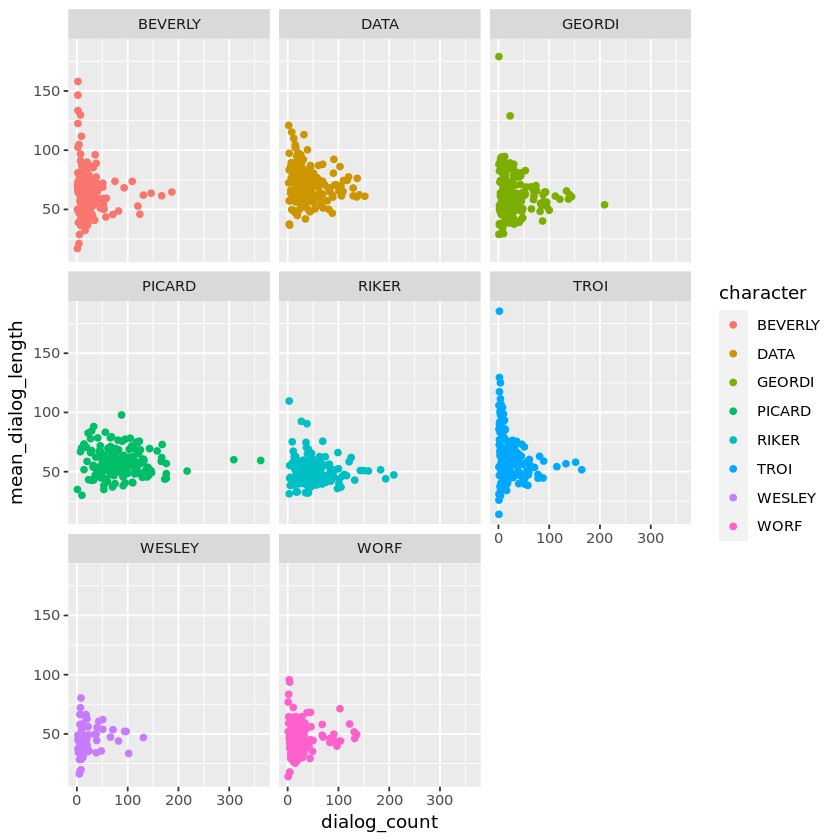

In [2]:
ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + 
    geom_point(aes(color=character)) + 
    facet_wrap(~character)

## Question 2
#### a) Compare Beverly's mean dialog per episode vs. mean dialog count per episode from season 1 (episodes 102-126) to season 3 (episodes 149-174) in a table.  
*Hints*:  
-   First, use `filter()` to get - 1) the dialog from only Beverly's character and 2) the episodes within the ranges given.
-   Then, add a season variable using `mutate()` with `case_when()`.
-   To create the means per episode, after your `mutate()` step, you'll need to `group_by()` season and episode number, then you can do your `summarize()` step to get the means by episode. At the end of the `summary()` statement (inside the parenthesis), add `.groups="drop"`. 
-   Then, to get the mean of means, you'll do the same as above, but only grouping by season. 

In [6]:
beverly_only <- dialogs_fixed %>%
  filter(character == "BEVERLY",
         (episode_number >= 102 & episode_number <= 126) | 
           (episode_number >= 149 & episode_number <= 174))

beverly_seasons <- beverly_only %>%
  mutate(season_number = case_when(
    episode_number >= 102 & episode_number <= 126 ~ "1",
    episode_number >= 149 & episode_number <= 174 ~ "3"),
    dialog_length = str_length(dialog)) %>%
  group_by(season_number, episode_number) %>%
  summarize(
    mean_dialog_length = mean(dialog_length), std_dialog_length  = sd(dialog_length), dialog_count       = n(),
    .groups = "drop")

beverly_mean_dialog <- beverly_seasons %>%
  group_by(season_number) %>%
  summarize(mean_length_per_ep = mean(mean_dialog_length), .groups = "drop")

print(beverly_mean_dialog)

# A tibble: 2 × 2
  season_number mean_length_per_ep
  <chr>                      <dbl>
1 1                           56.5
2 3                           67.0


#### b) In class, we talked about this character saying the actress has stated that after she was fired and rehired, the writers began giving her storylines that made her feel like a male character. How is this reflected in our table?

We can see that the actress had a higher mean length of dialogue in season 3 compared to season 1; this likely signals that as a more fleshed-out character, she had more opportunities to speak longer lines (and likely more significant lines) by season 3.


## Question 3
Let's compare the vocabulary richness (unique words / total words) of each character. 
#### a) Tokenize dialog into words, remove punctuation, convert to lowercase. Then filter out the stop words in the list below (from https://gist.github.com/sebleier/554280).
*Hint*: Here's a template for that this step should look like:
```
tokens <- YOUR_DATASET %>%
  # Split each dialog into words
  mutate(word_list = str_split(DIALOG_COLUMN, "\\s+")) %>%
  
  # Unnest the list column so each word is a row
  unnest(word_list) %>%
  
  # Clean words
  mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),  # Remove punctuation
    word = str_to_lower(word)                         # Convert to lowercase
  ) %>%
  
  # Remove empty strings and stopwords
  filter(word != "", !word %in% STOPWORDS)
```

In [7]:
stop_words <- c(
  "i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself",
  "yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself",
  "they","them","their","theirs","themselves","what","which","who","whom","this","that",
  "these","those","am","is","are","was","were","be","been","being","have","has","had",
  "having","do","does","did","doing","a","an","the","and","but","if","or","because","as",
  "until","while","of","at","by","for","with","about","against","between","into","through",
  "during","before","after","above","below","to","from","up","down","in","out","on","off",
  "over","under","again","further","then","once","here","there","when","where","why","how",
  "all","any","both","each","few","more","most","other","some","such","no","nor","not",
  "only","own","same","so","than","too","very","s","t","can","will","just","don","should","now"
)

In [8]:
tokens <- dialogs_fixed %>%
  # Split each dialog into words
  mutate(word_list = strsplit(dialog, "\\s+")) %>%
  
  # Unnest the list column so each word is a row
  unnest(word_list) %>%
  
  # Clean words
  mutate(
    word = gsub("[[:punct:]]", "", word_list),  # Remove punctuation
    word = tolower(word)                        # Convert to lowercase
  ) %>%
  
  # Remove empty strings and stopwords
  filter(word != "", !word %in% stop_words)

#### b) Count unique words per character. Print a summary table with the following columns: character, total words, unique words, and vocabulary richness.  
*Hint*: Group by character, then use `summarize()` to get what you want. You'll use `n_distinct()` to get the unique word counts. Arrange in descending value of vocabulary richness.

In [11]:
vocab_table <- tokens %>%
  group_by(character) %>%
  summarize(
    words_total = n(),                    
    words_distinct = n_distinct(word),      
    richness = words_distinct / words_total,  
    .groups = "drop") %>%
    arrange(desc(richness)) 

#### c) Plot total words versus vocab richness. 
-   Use the character names as the "points".
    -   *Hint*: Use `geom_text()` to add the character names as the points.
-   Do not include a legend.
    -   *Hint*: Use `theme()` to remove the legend.
-   Add a title and axis titles.
    -   *Hint*: Use `labs()` to add titles.

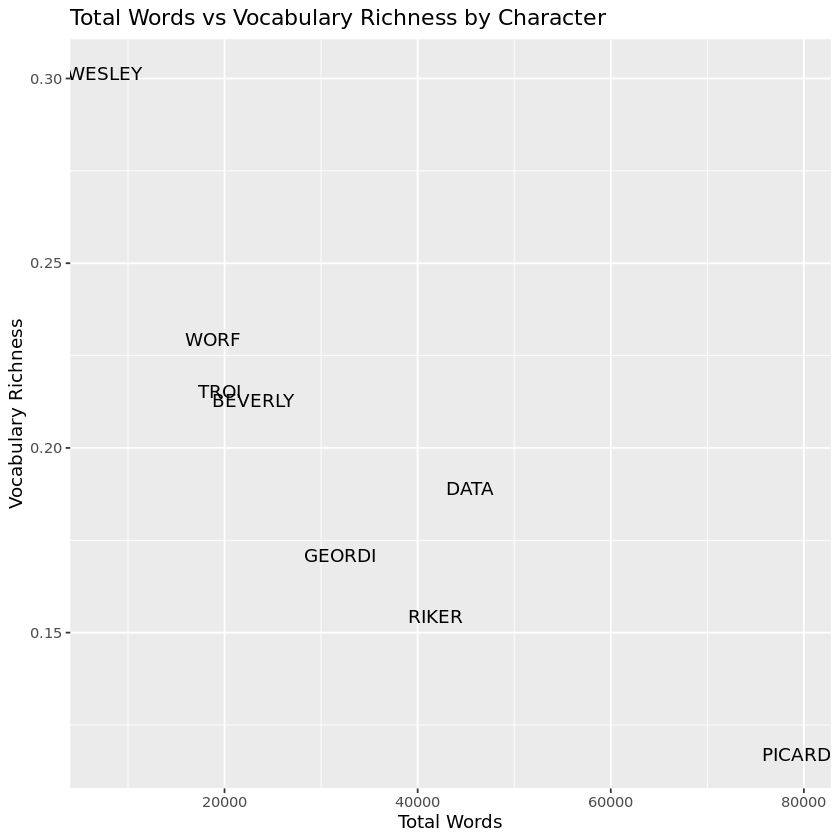

In [14]:
ggplot(vocab_table, aes(words_total, richness, label = character)) +
  geom_text() +
  theme() +
  labs(title = "Total Words vs Vocabulary Richness by Character",
      x = "Total Words",
      y = "Vocabulary Richness") 

#### d) Interpret these results. 

Picard has high total words, as the previous graph implied, but extremely low vocabulary richness. The two appear to be roughly negatively associated; Wesley has high vocabulary richness and low total words. This inverse relationship may be because when you are speaking more sentences, this necessitates repetition of certain common words which are the building blocks of English. Beverly and Troi again look similar (like in the visualization in Question 1 above); if they are the only 2 women in this list of characters, that is telling. The writers may write them similarly on account of their both being women.

## Question 4
#### a) Find what episode Wesley left the show as a main character and state it explicitly. Meaning, find the first significant gap where he is not found in more than two episodes in a row. 
*Hint*: It's after season 3 (ended at episode 174), so you can filter out seasons 1-3 and print Wesley's dialog count per episode. Then, scan the table for the gap. 

In [15]:
wesley_gone <- dialogs_fixed %>%
  filter(character == "WESLEY", episode_number >= 174) %>%
  group_by(episode_number) %>%
  summarize(dialog_count = n(), .groups = "drop") %>%
  arrange(episode_number)

#### b) After Wesley leaves the main cast, in which episodes does he make cameo appearances?

He appears to make an appearance in episodes 206, 219, 263, and 272.

#### c) Dig back into the data. Print:
-   Wesley's last piece of dialog before he left the main cast.
-   Wesley's last piece of dialog ever.  
  
*Hint*: To do this, you'll need to filter the `dialogs_fixed` data set to Welsey's lines and the episode number, and use `slice_tail(n = 1)` to get the last observation.

Last from episode 183: "I can walk."

Last from episode 272: "Good-bye, Mom."

In [16]:
wesley_last183 <- dialogs_fixed %>%
  filter(character == "WESLEY", episode_number == 183) %>%
  slice_tail(n = 1) 

wesley_last272 <- dialogs_fixed %>%
  filter(character == "WESLEY", episode_number == 272) %>%
  slice_tail(n = 1) 

print(wesley_last183)
print(wesley_last272)

# A tibble: 1 × 4
  episode_number character dialog      dialog_length
           <dbl> <chr>     <chr>               <int>
1            183 WESLEY    I can walk.            11
# A tibble: 1 × 4
  episode_number character dialog         dialog_length
           <dbl> <chr>     <chr>                  <int>
1            272 WESLEY    Good-bye, Mom.            14


## Question 5
Create a heatmap with `dialog_len_per_ep` showing mean dialog length per episode for each character. Sort the characters on the y-axis by their overall mean dialog length, with the lowest on top using a factor. Add a title and an axis title. 
*Hints*:
For the factor:
1. Compute overall mean (mean of mean) dialog length per character (`group_by()` then `summarize()`), and arrange the overall mean in ascending order. Add `pull(character)` to the end of this step so that you can use character as a factor in the next step. Store all of this in a new tibble.
2. Convert character to factor with this order. On `dialog_len_per_ep`, you'll use a mutate statement to add the factor `(mutate(character = factor(character, levels = DATAFROMHINT1))`.
3. Create heatmap using `geom_tile()`.
4. If you want nicer colors, you can add `scale_fill_viridis_c()` (or another color scale) to your ggplot statement. **Not required**, but fun to mess around with!

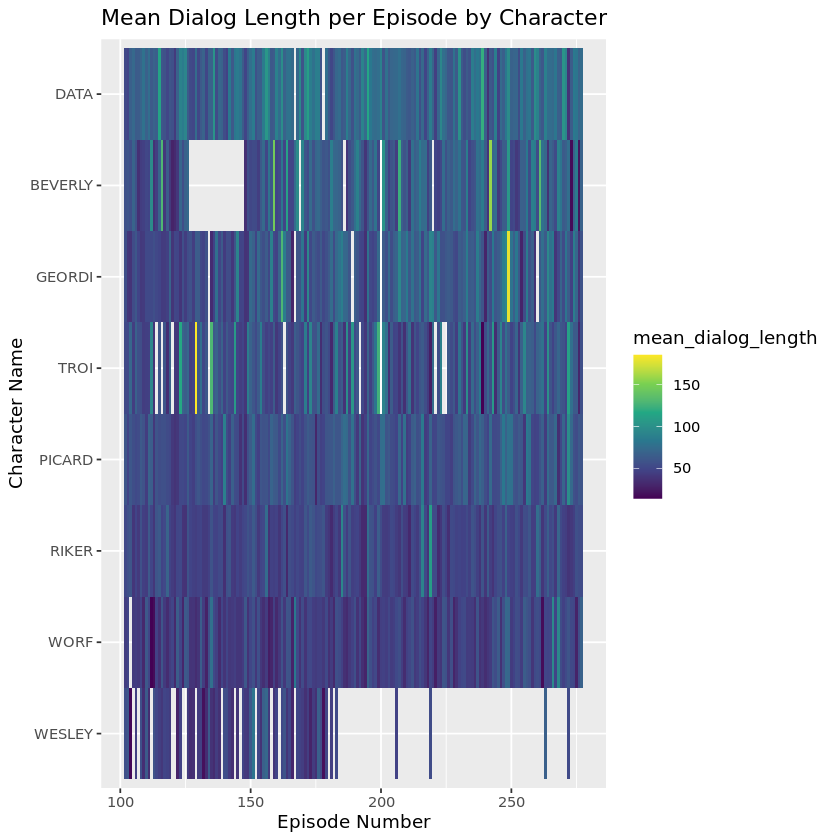

In [18]:
mean_length_tibble <- dialog_len_per_ep %>%
  group_by(character) %>%
  summarize(mean = mean(mean_dialog_length), .groups = "drop") %>%
  arrange(mean)

mean_length <- dialog_len_per_ep %>%
  group_by(character) %>%
  summarize(mean = mean(mean_dialog_length), .groups = "drop") %>%
  arrange(mean) %>%
  pull(character)

ml_factor <- dialog_len_per_ep %>%
  mutate(character = factor(character, levels = mean_length))

ggplot(ml_factor, aes(episode_number, character, fill = mean_dialog_length)) +
  geom_tile() +
  theme() +
  labs(
    title = "Mean Dialog Length per Episode by Character",
    x = "Episode Number",
    y = "Character Name") +
    scale_fill_viridis_c()